# Fruit Classification Using Transfer Learning

Project for IBM AI Engineering certification course.

## Modules

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [2]:
!pip install tensorflow matplotlib numpy scipy scikit-learn -q

In [3]:
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import random
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

## Dataset

In [4]:
path = kagglehub.dataset_download("moltean/fruits")
print(path)

Using Colab cache for faster access to the 'fruits' dataset.
/kaggle/input/fruits


In [5]:
train_dir = path + '/fruits-360_original-size/fruits-360-original-size/Training'
val_dir = path + '/fruits-360_original-size/fruits-360-original-size/Validation'
test_dir = path + '/fruits-360_original-size/fruits-360-original-size/Test'

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

Found 43009 images belonging to 121 classes.
Found 21511 images belonging to 121 classes.
Found 21379 images belonging to 121 classes.


## Model

In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])


In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


### Training

In [9]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

set_global_policy('mixed_float16')

steps_per_epoch = 50
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.0279 - loss: 5.0593 - val_accuracy: 0.0125 - val_loss: 4.6096 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.1132 - loss: 4.1422 - val_accuracy: 0.1025 - val_loss: 4.1693 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.1573 - loss: 3.7780 - val_accuracy: 0.2100 - val_loss: 3.7675 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.2090 - loss: 3.4065 - val_accuracy: 0.2925 - val_loss: 3.3648 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.2332 - loss: 3.2002 - val_accuracy: 0.3075 - val_loss: 3.0510 - learning_rate: 0.0010


In [10]:
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

for layer in base_model.layers[-5:]:
    layer.trainable = True

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.2842 - loss: 2.9169 - val_accuracy: 0.3625 - val_loss: 2.6548 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.3323 - loss: 2.6959 - val_accuracy: 0.4100 - val_loss: 2.4632 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.3302 - loss: 2.7641 - val_accuracy: 0.4575 - val_loss: 2.2647 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.3985 - loss: 2.5442 - val_accuracy: 0.4675 - val_loss: 2.1169 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.3636 - loss: 2.6396 - val_accuracy: 0.5275 - val_loss: 2.0860 - learning_rate: 1.0000e-05


### Evaluation

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4835 - loss: 2.1375
Test Accuracy: 0.49


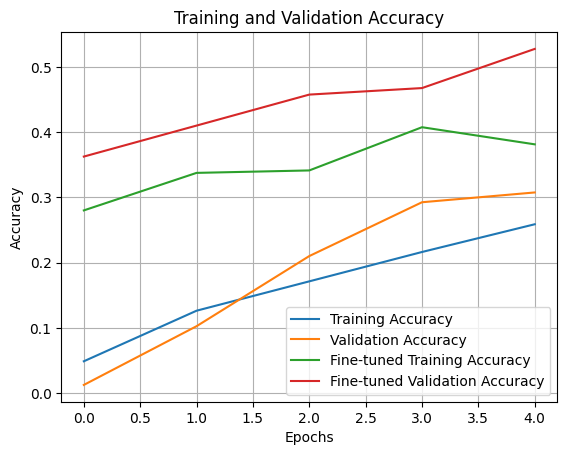

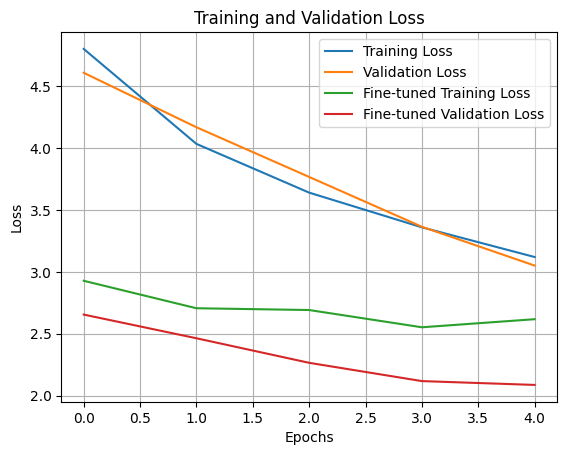

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


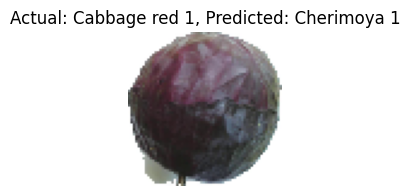

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


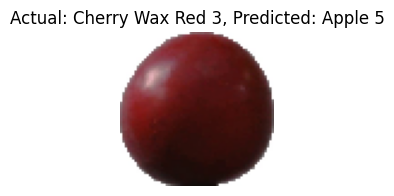

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


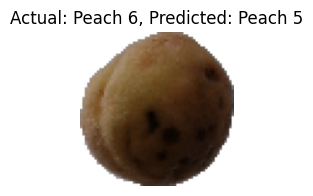

In [13]:
actual_count = Counter()
predicted_count = Counter()

def get_class_name_from_index(predicted_index, class_index_mapping):
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"

def visualize_prediction_with_actual(img_path, class_index_mapping):
    class_name = os.path.basename(os.path.dirname(img_path))

    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

class_index_mapping = train_generator.class_indices

base_dir = Path(path) / 'fruits-360_original-size/fruits-360-original-size/Test'
all_jpgs = list(base_dir.rglob('*.jpg'))
sample_images = random.sample(all_jpgs, 3)
sample_images = [str(p) for p in sample_images]

for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)